# FLIP (02) Optimization Data Science

---
Team Director: Meng Ren | mren@tulip.academy<br />

TULIP Academy <br />
http://www.tulip.academy 

---

Boundary Value Problems
=======================

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)

For IVPs need both the system of differential equations

$${\boldsymbol{y}}'(x) = {\boldsymbol{f}}(x, {\boldsymbol{y}}(x))$$

and the initial data ${\boldsymbol{y}}_0 = {\boldsymbol{y}}(0)$ to
specify unique solution.

Instead specify solution in $x \in [0, b]$ by giving some data at $x=0$
and some at $x=b$. Given exactly $n$ independent conditions we have a
unique solution. This is a *Boundary Value Problem* (BVP).

A single ODE ($n=1$) is always an IVP. Simplest BVP is system size
$n=2$. Typically write this as one equation,

$$y'' = f(x, y, y'), \quad y(a) = A, \,\, y(b) = B, \quad x \in [a,b].$$

Boundary conditions only examples – could specify e.g. derivative at one
boundary.

### General points on BVPs

For IVPs always chose to use form of a first order system. Can do same
for BVPs:

$${\boldsymbol{y}}'(x) = {\boldsymbol{f}}(x, {\boldsymbol{y}}(x)), \quad {\boldsymbol{y}}(a) = {\boldsymbol{y}}_a, \,\,{\boldsymbol{y}}(b) =
{\boldsymbol{y}}_b, \quad x \in [a,b].$$

Interpretation: specifying $n_a$ components of ${\boldsymbol{y}}_a$ and
$n_b$ components of ${\boldsymbol{y}}_b$ ($n_a + n_b = n$).

First order form required by Matlab solvers (bvp4c, bvp5c).

In general instead use the form

$${\boldsymbol{y}}'' = {\boldsymbol{f}} \left( x, {\boldsymbol{y}}, {\boldsymbol{y}}' \right)$$

as more straightforward to motivate the methods.

Shooting
--------

Simple idea:

1.  convert BVP to IVP by *guessing* additional initial conditions
${\boldsymbol{y}}_a$;
2.  solve IVP and check (dis)agreement with conditions for end point,
${\boldsymbol{y}}_b$;
3.  modify initial guess until solved.

More formally, look at simple problem

$$y'' = f(x, y, y'), \quad y(a) = A, \,\, y(b) = B, \quad x \in
[a,b].$$
Convert to IVP

$$y'' = f(x, y, y'), \quad y(a) = A, \,\, y'(a) = z$$

where $z$ is initially unknown. Solution $y$ depends on $x$, but also on
$z$. Aim: find $z$ such that $y(b) = B$.

### Shooting and root finding

Write solution to IVP

$$y'' = f(x, y, y'), \quad y(a) = A, \,\, y'(a) = z$$

as $y(x, z)$ to encode dependence on $z$. Condition to enforce is

$$y(b, z) = B.$$

Define function

$$\phi(z) = y(b, z) - B.$$

The root $\phi(z) = 0$ gives required value of $z$.

Shooting involves finding root of a nonlinear function (see the 3018
notes); evaluating function at any point involves solving an IVP!

Example
-------

Consider problem

$$y'' + y' + 1 = 0, \quad y(0) = 0, \,\, y(1) = 1, \quad x \in [0, 1].$$

First reformulate as the IVP

$$y'' + y' + 1 = 0, \quad y(0) = 0, \,\, y'(0) = z.$$

Then reformulate IVP in first order form,

$$\begin{aligned}
  y_1' & = y_2, & y_1(0) & = 0 \\
  y_2' & = -1 - y_2, & y_2(0) & = z.
\end{aligned}$$

Want to solve this IVP, modifying $z$ such that

$$\phi(z) = y(1) - 1 = y_1(1) - 1.$$

Use Matlab’s ode45 to solve IVP, and secant method to find root, to
solve

$$\begin{aligned}
y'' + y' + 1 &= 0, \\ y(0) &= 0, \\ y(1) &= 1, \\ x &\in [0, 1].
\end{aligned}$$

Secant method requires two guesses for $z$; use $0, 10$ which bracket
the root.

In [3]:
from scipy.integrate import odeint
from scipy.optimize import brentq

In [4]:
def shooting_ivp(Z, x):
    dZdt = np.zeros_like(Z)
    dZdt[0] = Z[1]
    dZdt[1] = -1.0 - Z[1]
    
    return dZdt

def shooting_function(z):
    x = [0.0, 1.0]
    Z0 = [0.0, z]
    Z = odeint(shooting_ivp, Z0, x)
    phi = Z[-1, 0] - 1
    
    return phi

In [5]:
z0 = brentq(shooting_function, 0.0, 10.0)
print("The correct value of the derivative at x = 0 is {}.".format(z0))

The correct value of the derivative at x = 0 is 2.1639534124725284.


We can now look at the solution constructed at the two initial guesses for $z$, $0$ and $10$, and the final value: the final value should correspond to the solution for the boundary value problem.

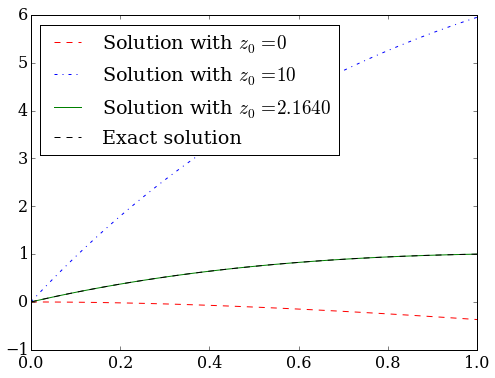

In [6]:
x = np.linspace(0.0, 1.0, 100)
Z0_0 = [0.0, 0.0]
Z0_10 = [0.0, 10.0]
Z0_soln = [0.0, z0]
Z_0 = odeint(shooting_ivp, Z0_0, x)
Z_10 = odeint(shooting_ivp, Z0_10, x)
Z_soln = odeint(shooting_ivp, Z0_soln, x)

y_exact = 2.0 * np.exp(1.0) / (np.exp(1.0) - 1.0) * (1.0 - np.exp(-x)) - x

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x, Z_0[:, 0], 'r--', label = "Solution with $z_0 = 0$")
ax.plot(x, Z_10[:, 0], 'b-.', label = r"Solution with $z_0 = 10$")
ax.plot(x, Z_soln[:, 0], 'g-', label = r"Solution with $z_0 = {:.4f}$".format(z0))
ax.plot(x, y_exact, 'k--', label = r"Exact solution")
ax.legend(loc = 2)
plt.show()

The problem

$$y'' + y' + 1 = 0, \quad y(0) = 0, \,\, y(1) = 1, \quad x \in [0, 1]$$

can be solved “analytically” using shooting. The new IVP

$$y'' + y' + 1 = 0, \quad y(0) = 0, \,\, y'(0) = z$$

can be solved directly to find

$$y(x, z) = (1 + z) (1 - e^{-x}) - x.$$

Then find $z$ such that solution satisfies boundary condition $y(1,
  z) = 1$; equivalently, find the root of

$$\phi(z) = y(1, z) - 1.$$

This gives the exact solution

$$y(x) = \frac{2 e}{e - 1} (1 - e^{-x}) - x.$$

Root finding for shooting
-------------------------

For shooting method need to

1.  solve IVPs (previous section)

2.  find roots of nonlinear equations (3018 notes).

For root finding, construct a sequence that converges to root; often use
*secant* method

$$z_{n+1} = z_n + \phi(z_n) \frac{z_n - z_{n-1}}{\phi(z_n) -
\phi(z_{n-1})}$$
or *Newton’s* method

$$z_{n+1} = z_n - \frac{\phi(z_n)}{\phi'(z_n)}.$$

Secant method needs two guesses and one function evaluation; Newton
needs one guess but two function evaluations, one of $\phi'$.

Secant usually preferable: simpler, normally just as efficient.
Sometimes the better convergence of Newton’s method useful.

### Newton’s method for root finding

Newton’s method

$$z_{n+1} = z_n - \frac{\phi(z_n)}{\phi'(z_n)}$$

requires the derivative of the function

$$\phi(z) = y(b, z) - B.$$

Could evaluate numerically using

$$\phi'(z_n) \simeq \frac{ \phi(z_n + h) - \phi(z_n) }{h}, \quad h
\ll 1.$$
But this is essentially the secant method, only less robust and
accurate.


Alternative: use *variational equation*. Introduce
$u(x,z) = \partial_z y$ and then differentiate *whole IVP*

$$y'' = f(x, y, y'), \quad y(a) = A, \,\, y'(a) = z$$

with respect to $z$, finding

$$u'' = (\partial_y f) u + (\partial_{y'} f) u', \quad u(a) = 0,
\,\, u'(a) = 1.$$
As $\phi'(z) = u(b, z)$, adding IVP for $u$ to system automatically
gives $\phi'$.

Problems with shooting
----------------------

For many problems shooting is effective: try it first. However, can fail
in some cases:

1.   Fails to satisfy all boundary conditions exactly. Usually a minor point, can be crucial in special cases.
2.   Root finding requires initial guess(es). With a poor guess method may not converge.
3.   BVP may have multiple solutions: shooting may converge to “wrong” one.
4.   IVP generated may be unstable, even for a well-behaved BVP.

### Multiple solutions

The example BVP

$$\begin{aligned}
y'' + y - 2 y \,\text{tanh}(y^2) & = 0, \\ y(0) &= 0, \\ y(8)
& = 1/2 
\end{aligned}$$

has more than one solution; resulting $\phi$ for root-find has strange
behaviour.

Zooming, see the roots are very close together; corresponding solutions
have different signs!

In [7]:
def shooting_ivp_multiple_solutions(Z, x):
    dZdt = np.zeros_like(Z)
    dZdt[0] = Z[1]
    dZdt[1] = 2.0 * Z[0] * np.tanh(Z[0]**2) - Z[0]
    
    return dZdt

def shooting_function_multiple_solutions(z0):
    x = [0.0, 8.0]
    Z0 = [0.0, z0]
    Z = odeint(shooting_ivp_multiple_solutions, Z0, x)
    phi = Z[-1, 0] - 0.5
    
    return phi

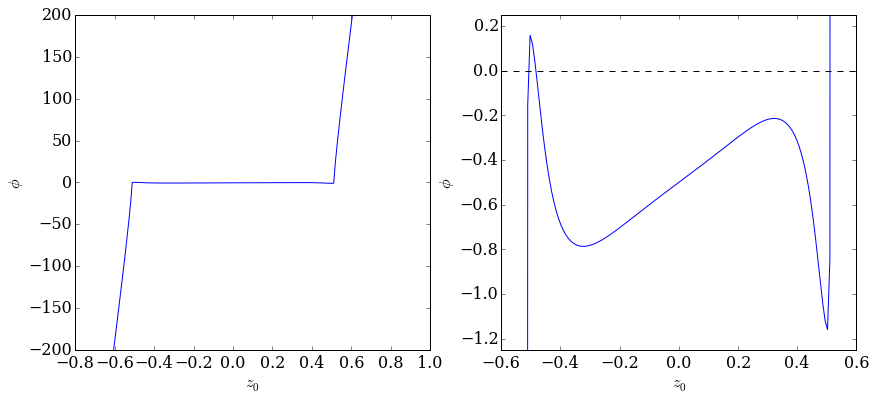

In [8]:
z0 = np.linspace(-0.8, 0.8, 200)
phi = np.zeros_like(z0)
for i in range(len(z0)):
    phi[i] = shooting_function_multiple_solutions(z0[i])
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.plot(z0, phi)
ax1.set_ylim([-200.0, 200.0])
ax1.set_xlabel("$z_0$")
ax1.set_ylabel("$\phi$")
ax2 = fig.add_subplot(122)
ax2.plot(z0, phi)
ax2.set_xlabel("$z_0$")
ax2.set_ylabel("$\phi$")
ax2.set_xlim([-0.6, 0.6])
ax2.set_ylim([-1.25, 0.25])
ax2.axhline(color='black', linestyle='--')
plt.show()

We can now use root finding methods to find the three roots. Remember, if the physical solution must be positive then only one solution of the BVP is acceptable, and that solution will be very difficult for the root finding method to converge to.

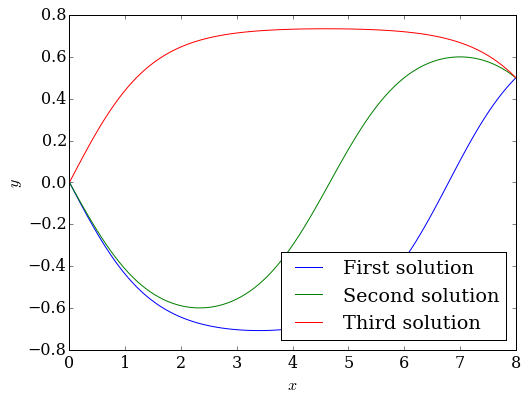

In [9]:
root_0 = brentq(shooting_function_multiple_solutions, -0.6, -0.5)
root_1 = brentq(shooting_function_multiple_solutions, -0.5, -0.4)
root_2 = brentq(shooting_function_multiple_solutions, 0.4, 0.6)

x = np.linspace(0.0, 8.0, 100)
Z_0 = odeint(shooting_ivp_multiple_solutions, [0.0, root_0], x)
Z_1 = odeint(shooting_ivp_multiple_solutions, [0.0, root_1], x)
Z_2 = odeint(shooting_ivp_multiple_solutions, [0.0, root_2], x)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x, Z_0[:, 0], label='First solution')
ax.plot(x, Z_1[:, 0], label='Second solution')
ax.plot(x, Z_2[:, 0], label='Third solution')
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend(loc=4)
plt.show()

### Unstable IVP

The example BVP

$$\begin{aligned}
y'' + y - y^3  &= 0, \\ y(0) & = 0, \\ y(3) & = 1
\end{aligned}$$

has well-behaved single solution. The IVP solutions have very different
behaviour as $z$ is varied. Usually IVP method diverges before finding
root.

In [10]:
def shooting_ivp_unstable(Z, x):
    dZdt = np.zeros_like(Z)
    dZdt[0] = Z[1]
    dZdt[1] = Z[0]**3 - Z[0]
    
    return dZdt

x = np.linspace(0.0, 3.0, 100)
z0 = np.linspace(0.2, 0.9, 8)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i in range(len(z0)):
    Z = odeint(shooting_ivp_unstable, [0.0, z0[i]], x)
    ax.plot(x, Z[:, 0])
ax.set_ylim([-0.2, 1.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.show()

Summary
=======

-   Boundary value problems (BVPs) are ODEs where not all the conditions
required to specify the problem on the interval $x \in
    [a,b]$ are given at a single point.
-   Shooting methods convert the BVP to an IVP with some free initial
data; the free data is modified to fit the boundary conditions at
the “end” of the interval. This requires nonlinear root finding.
-   The secant method is the standard nonlinear root finding method
used; if the additional convergence of Newton’s method is required
the variational equation is typically needed to evaluate the
derivative of the nonlinear function.
-   Shooting methods, when they work, are fast and accurate. However,
they fail to *exactly* satisfy the boundary conditions at the “end”
of the interval, and there are problems for which the BVP is
well-posed but the IVP used in the shooting method is not.